In [ ]:
#https://www.kaggle.com/c/nlp-getting-started/overview

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, GlobalAveragePooling1D, LSTM, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay
from wordcloud import WordCloud
import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [6]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

In [3]:
trainset.sample(5,random_state=42)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
#check if there are missing data
trainset.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

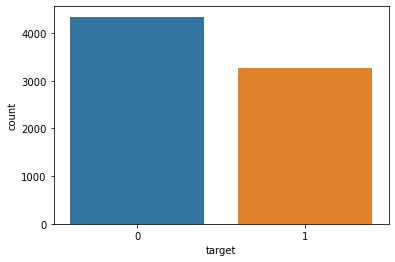

In [23]:
sb.countplot(x=trainset['target'])

In [53]:
def text_len(target):
    return trainset[trainset.target == target]['text'].str.split().apply(lambda x: len(x))

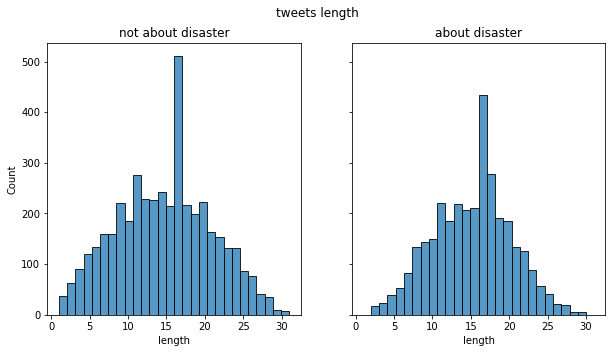

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
sb.histplot(text_len(0),ax=ax1)
sb.histplot(text_len(1),ax=ax2)
fig.suptitle('tweets length')
ax1.set_title('not about disaster')
ax2.set_title('about disaster')
ax1.set_xlabel('length')
ax2.set_xlabel('length')
plt.show()

In [15]:
def make_cloud(target):
    keywords = ' '.join(list(trainset.loc[trainset['text'].notna() & trainset.target == target]['text']))
    cloud = WordCloud(collocations=False, width = 800, height = 800,
                    background_color ='white').generate(keywords)
    plt.figure(figsize=(16,9))
    plt.imshow(cloud)

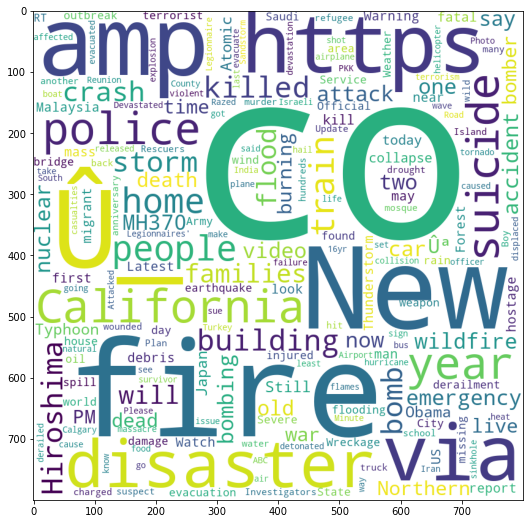

In [16]:
#wordcloud of texts from class 1
make_cloud(1)

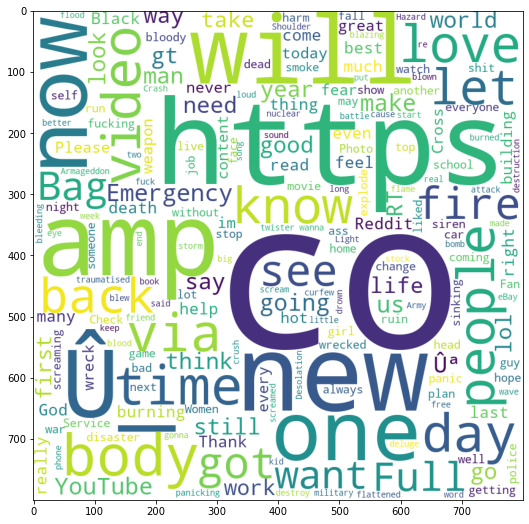

In [17]:
#wordcloud of texts from class 0
make_cloud(0)

In [7]:
def remove_accent(text):
    return unidecode.unidecode(text)

def preprocess(text):
    #remove url
    text = re.sub(r'\w+:\/\/\S*', ' ', text.lower())
    
    #remove tags
    text = re.sub(r'<.*?>', ' ',text)
    
    #remove emails
    text = re.sub(r'\S*@\S*', ' ', text)
    
    #remove hashtags
    text = re.sub(r'\S*#\S*',' ', text)
    
    #remove accented characters
    text = unidecode.unidecode(text)
    
    #remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #remove single character
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    #lastly remove spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stopwords
    stopwords_ = stopwords.words('english') + ['would', 'omg']
    text = [w for w in text.split() if w not in stopwords_]
    
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    
    return ' '.join(text)

In [77]:
s = trainset.loc[548].text
print(f'raw:\n{s}')
print(f'cleaned:\n{preprocess(s)}')

raw:
CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL 2nd NEW HAMPSHIRE LETTER SIGNED ! http://t.co/Ot0tFFpBYB http://t.co/zaRBwep9LD
cleaned:
civil war general battle bull run hero colonel nd new hampshire letter signed


In [8]:
trainset['clean_text'] = trainset['text'].apply(lambda x: preprocess(x))
trainset.sample(5,random_state=42)

,id,keyword,location,text,target,clean_text
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,new weapon cause un imaginable destruction
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,thing got soaked deluge going pad tampon thx
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,dt rt uithe col police catch pickpocket liverp...
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,aftershock back school kick great want thank e...
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,response trauma child addict develop defensive...


In [9]:
#prepare data
x_train, x_val, y_train, y_val = train_test_split(trainset['clean_text'], 
                                                  trainset['target'], stratify=trainset['target'],
                                                  test_size=0.33, random_state=42)

In [10]:
embedding_dim = 200
max_len = 15
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [11]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

x_train = pad_sequences(x_train, padding=padding_type, truncating=trunc_type, maxlen=max_len)
x_val = pad_sequences(x_val, padding=padding_type, truncating=trunc_type, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

In [12]:
embeddings_index = {}
glo = './glove/glove.twitter.27B.200d.txt'

with open(glo, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'found {len(embeddings_index)} word embeddings')

found 1193514 word embeddings


In [13]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
vec_count = 0
no_vec = []
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        vec_count += 1 
    else:
        no_vec.append(word)
print(f'embedding vectors cover {round(vec_count / vocab_size * 100, 2)}% of words in the text')

embedding vectors cover 90.62% of words in the text


In [91]:
len(no_vec)

893

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=9e-5),
              metrics=['accuracy'])

In [16]:
earlystopping = EarlyStopping(monitor = 'val_loss', 
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [17]:
hist = model.fit(x_train, y_train, 
                 batch_size=32, epochs=30,verbose=2,
                 validation_data=(x_val, y_val),
                 callbacks=[earlystopping, lr])

Epoch 1/30
160/160 - 9s - loss: 0.6358 - accuracy: 0.6843 - val_loss: 0.5592 - val_accuracy: 0.7772
Epoch 2/30
160/160 - 9s - loss: 0.5248 - accuracy: 0.7616 - val_loss: 0.4768 - val_accuracy: 0.7851
Epoch 3/30
160/160 - 9s - loss: 0.4855 - accuracy: 0.7788 - val_loss: 0.4606 - val_accuracy: 0.8002
Epoch 4/30
160/160 - 9s - loss: 0.4717 - accuracy: 0.7765 - val_loss: 0.4493 - val_accuracy: 0.7994
Epoch 5/30
160/160 - 10s - loss: 0.4573 - accuracy: 0.7941 - val_loss: 0.4459 - val_accuracy: 0.8058
Epoch 6/30
160/160 - 10s - loss: 0.4565 - accuracy: 0.7920 - val_loss: 0.4441 - val_accuracy: 0.8066
Epoch 7/30
160/160 - 10s - loss: 0.4476 - accuracy: 0.7973 - val_loss: 0.4415 - val_accuracy: 0.8050
Epoch 8/30
160/160 - 10s - loss: 0.4409 - accuracy: 0.8037 - val_loss: 0.4380 - val_accuracy: 0.8098
Epoch 9/30
160/160 - 10s - loss: 0.4401 - accuracy: 0.8018 - val_loss: 0.4381 - val_accuracy: 0.8094
Epoch 10/30
160/160 - 10s - loss: 0.4360 - accuracy: 0.8020 - val_loss: 0.4360 - val_accuracy: 

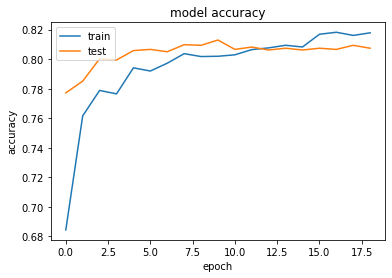

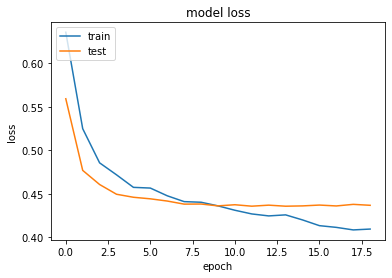

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
y_val_score = model.predict(x_val)

In [36]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_score)

In [37]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

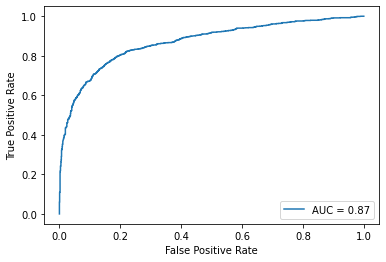

In [43]:
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot()

In [46]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.36225772


In [49]:
gate = optimal_threshold
y_val_score[y_val_score > gate] = 1
y_val_score[y_val_score < gate] = 0
y_val_score = y_val_score.astype('int')

In [50]:
print(classification_report(y_val, y_val_score))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1433
           1       0.77      0.78      0.78      1080

    accuracy                           0.81      2513
   macro avg       0.80      0.80      0.80      2513
weighted avg       0.81      0.81      0.81      2513

